<a href="https://colab.research.google.com/github/toaomalkster/conscious-calculator-notebooks/blob/main/src/scratch/notebooks/number-adder/NumberAdder_0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number Adder
0.4:
* Running model in a loop with feedback
* Beginnings of a re-inforcement style loss function:
  * Input presented only on first iteration
  * Loss measures output nodes only, summed across all iterations.

## Background
Building up towards a model based on Consciousness V2 theory.

## Loss Function Considerations
Non-negotiables:
* Must produce the correct result at some point
* Must not falsely represent the result -- ie: if there is a 'completion' flag, then it must always be close to zero if not outputting the result

Fuzzy requirements:
* Accuracy is more important than efficiency
* Needs to identify 'completion' somehow

Ideal optimisation requirements:
* Minimise effort to produce result
  * Optimises for quicker response times
  * Also a protection against infinite loops

**App Boilerplate**

In [ ]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)


2.3.0


# Setup Training Data

In [ ]:
data = np.random.randint(100, size=(1000, 2)).astype('float32')
data[0:10,:]

array([[26., 39.],
       [22., 17.],
       [55., 30.],
       [87., 86.],
       [32., 44.],
       [44., 14.],
       [85., 40.],
       [94., 14.],
       [90., 12.],
       [26., 18.]], dtype=float32)

In [ ]:
data_labels = (data[:,0] + data[:,1])[:,np.newaxis]
data_labels[0:10,:]

array([[ 65.],
       [ 39.],
       [ 85.],
       [173.],
       [ 76.],
       [ 58.],
       [125.],
       [108.],
       [102.],
       [ 44.]], dtype=float32)

# Setup Model

In [ ]:
statusNodes=1
outputNodes=1
feedbackNodes=5
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(2+feedbackNodes,)),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(statusNodes + outputNodes + feedbackNodes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1000)              8000      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 7007      
Total params: 15,007
Trainable params: 15,007
Non-trainable params: 0
_________________________________________________________________


# Setup Training
Running equivalent of:
```
# fitres = model.fit(data, data_labels, validation_split=0.2, shuffle=True, epochs=150)
```

Trained to run with loop length 5, and asked to calculate 78 + 14, gives the following sub-results:
```
(tbd)
```
And the following final result:
```
(tbd)
```

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def multiIterationLoss(y_true, y_preds):
  """Computes re-inforcement loss across loop execution.

  Args:
    y_true: Ground truth values.
            Expected outcome, without status or feedback nodes.
            shape = `[batch_size, d0, .. dN]`.
    y_preds: The predicted values across all iterations of the loop.
            Excluding feedback nodes.
            shape = `[batch_size, loop_size, d0, .. dN]`.

  Returns:
    Mean absolute error values. shape = `[batch_size, d0, .. dN-1]`.
  """

  # Simple implementation - mse on last iteration
  lastPreds = y_preds[..., -1:]
  return loss(y_true, lastPreds)

@tf.function
def compute(inputs, max_loop_length, training=False):
  batchSize = inputs.shape[0]
  outputs = None
  feedback = tf.zeros(shape=(batchSize, feedbackNodes))

  for i in range(max_loop_length):
    # extend width of inputs with zeroed-out feedback
    if i == 0:
      inputsWithFeedback = tf.concat([inputs, feedback], axis=1)
    else:
      zeroedInputs = tf.zeros(shape=inputs.shape)
      inputsWithFeedback = tf.concat([zeroedInputs, feedback], axis=1)
  
    # run model with inputs + feedback nodes
    output = model(inputsWithFeedback, training)

    # copy feedback for next iteration
    feedback = output[:,-feedbackNodes:]

    # produce output for records
    # (note: doesn't use TF functions so don't re-use any of this for next iteration)
    outputWithoutFeedback = output[:,:-feedbackNodes]
    if outputs == None:
      outputs = outputWithoutFeedback
    else:
      outputs = tf.concat([outputs, outputWithoutFeedback], axis=tf.rank(output)-1)

  return outputs

def predict(inputs, max_loop_length, training=False):
  # pick last output only
  return compute(inputs, max_loop_length, training)[...,-1:]

@tf.function
def train_step(inputs, expected, max_loop_length):
  with tf.GradientTape() as tape:
    outputs = compute(inputs, max_loop_length, training=True)

    # calculate loss ignoring feedback output
    loop_loss = multiIterationLoss(expected, outputs)

    # train model
    gradients = tape.gradient(loop_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loop_loss

In [ ]:
def fit(train_data, train_labels, epochs, batch_size, max_loop_length):
  res = {}
  res['loss'] = []

  for epoch in range(epochs):
    print ('Epoch: {}/{}'.format(epoch+1, epochs))
    start = time.time()
    sum_loss = 0

    # Train in batches
    mx = (int(len(train_data)/batch_size))*batch_size
    n  = mx/batch_size
    print ('[', end='')
    for i in range(0, mx, batch_size):
      batch_data   = train_data[i:i+batch_size]
      batch_labels = train_labels[i:i+batch_size]
      sum_loss += train_step(batch_data, batch_labels, max_loop_length)
      print ('=', end='')
    print('] - {} sec - loss: {}'.format(time.time()-start, sum_loss/n))

    # Record history
    res['loss'].append(sum_loss/n)

  return res

# Run Training

In [ ]:
fitres = fit(data, data_labels, epochs=150, batch_size=32, max_loop_length=5)

Epoch: 1/150
[===============================] - 1.1250157356262207 sec - loss: 11411.986328125
Epoch: 2/150
[===============================] - 0.06854486465454102 sec - loss: 1316.2462158203125
Epoch: 3/150
[===============================] - 0.07159185409545898 sec - loss: 10.530560493469238
Epoch: 4/150
[===============================] - 0.06616520881652832 sec - loss: 5.5740814208984375
Epoch: 5/150
[===============================] - 0.06700420379638672 sec - loss: 2.6126413345336914
Epoch: 6/150
[===============================] - 0.06859135627746582 sec - loss: 1.236127495765686
Epoch: 7/150
[===============================] - 0.06726646423339844 sec - loss: 0.6936963200569153
Epoch: 8/150
[===============================] - 0.07037186622619629 sec - loss: 0.4579700231552124
Epoch: 9/150
[===============================] - 0.0720064640045166 sec - loss: 0.331165075302124
Epoch: 10/150
[===============================] - 0.06828951835632324 sec - loss: 0.25160661339759827
Epoch

# Results

In [ ]:
print(['x', 'y', 'expected', 'actual'])
print(np.concatenate((data[800:810], data_labels[800:810], predict(data[800:810], 5)), axis=1))

['x', 'y', 'expected', 'actual']
[[ 16.        22.        38.        37.99337 ]
 [ 71.        32.       103.       102.90359 ]
 [ 96.         8.       104.       104.01371 ]
 [ 25.         5.        30.        29.998138]
 [ 89.         1.        90.        90.234   ]
 [ 80.        51.       131.       130.87273 ]
 [ 91.        61.       152.       151.81143 ]
 [ 51.        67.       118.       117.87354 ]
 [ 18.        94.       112.       112.06926 ]
 [ 49.        62.       111.       110.87208 ]]


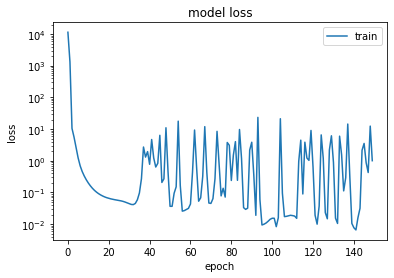

In [ ]:
plt.semilogy(fitres['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Analysis

In [ ]:
print(compute(data[800:810], 6))

tf.Tensor(
[[  5.771011   20.371477   23.920355   30.272678   37.99337    45.69409  ]
 [ 15.616522   55.15226    64.63598    81.82447   102.90359   123.81841  ]
 [ 17.807415   56.81425    64.948204   82.540215  104.01371   125.02814  ]
 [  4.8591256  16.312582   18.836002   23.856846   29.998138   36.03773  ]
 [ 16.193796   49.61068    56.246407   71.576546   90.234     108.426506 ]
 [ 19.661097   69.97412    82.24384   104.128685  130.87273   157.5225   ]
 [ 22.777464   81.154236   95.396835  120.78931   151.81143   182.7372   ]
 [ 17.674683   63.014286   74.050385   93.82217   117.87354   141.87302  ]
 [ 19.504698   59.9812     70.181145   89.13197   112.06926   134.81142  ]
 [ 16.601902   59.2815     69.661224   88.25177   110.87208   133.44398  ]], shape=(10, 6), dtype=float32)
